# Assigment 3

In [31]:
from sympy import * 
import numpy as np
import matplotlib.pyplot as plt
from dtumathtools import *
from sympy.physics.units import *
init_printing()  

## Task 2

In [ ]:
# Ingenuity original data
m_Ingenuity = 1.8 #kg
m_fus_Ingenuity = 0.3 #kg (mass of the fuselage)
m_no_fus_Ingenuity = m_Ingenuity - m_fus_Ingenuity #kg (mass of the rest of the drone)
d_prop_Ingenuity = 1.2 #m
R_prop_Ingenuity = d_prop_Ingenuity / 2 #m
n_prop_Ingenuity = 2 #number of propellers
n_blade_Ingenuity = 4 #number of blades
omega_Ingenuity = 2800 * pi / 30 #rad/s (propeller rotation speed)
P_hover_Ingenuity = 360 #W
P_peak_Ingenuity = 510 #W

P_motor_Ingenuity = 172/2 #W (Power consumption per motor/propeller in ingenuity from task #1)

# Mars atmosphere data
rho_mars = 0.017 #kg/m^3
g_mars = 3.71 #m/s^2

# Losses and other datapoints
C_d0 = 0.02 #zero-lift drag coefficient
gamma = 1.15 #Antaget
c = 0.14 #Antaget


# Ingenuity new data (general for both cases)
payload = 2 #kg
m_battery = 0.5 #kg
E_battery = 20 * 3600 #J (20 Wh)
m_computer = 1 #kg
m_constant = m_battery + m_computer + payload #kg


In [33]:
# Defining a function to solve for the mass of the drone iteratively

def Solve_mass(n_prop, n_blade, R_prop_guess):

    # Defining guesses for first iteration
    m_motor = 0.2 # kg
    R_prop = R_prop_guess # m (guess for rotor radius)

    # Omega calculation based on constant tip speed
    omega = (omega_Ingenuity * R_prop_Ingenuity)/(R_prop)

    for i in range(10):  # Number of iterations to find the optimal rotor length
        print('Iteration', i+1,':')

        # Initial mass calculation
        m_blade = (0.07/4) * n_blade * (R_prop/R_prop_Ingenuity) # Weight of blades 
        m_no_fus = m_constant + m_motor * n_prop + m_blade * n_prop #kg (weight of the fuselage without propellers)
        m_fus = m_no_fus * (m_fus_Ingenuity / m_no_fus_Ingenuity) #kg (weight of the fuselage with propellers)
        m_total = m_no_fus + m_fus #kg (total weight of the drone)

        # Trust calculation with m_total
        T = m_total * g_mars # thrust required to hover (N)
        T_rotor = T / n_prop # thrust per rotor (N)

        # Power calculation     
        P_ideal = (T_rotor**(1.5))/sqrt(2*np.pi*rho_mars*R_prop**2) #W (ideal power required to hover per propeller)
        P_0 = (1/8) * rho_mars * c * n_blade * C_d0 * omega**3 * R_prop**4 #W (power required to hover with losses per propeller)
        P = (gamma * P_ideal + P_0) * n_prop #W (Total power required to hover)
        print('Total power required to hover: ', round(P,4), 'W')

        # New mass calculation based on power
        m_blade = (0.07/4) * n_blade * (R_prop/R_prop_Ingenuity) # Weight of blades 
        m_motor = (0.25/2) * ((P/n_prop)/P_motor_Ingenuity) # Weight per motor required per propeller
        m_no_fus = m_constant + m_motor * n_prop + m_blade * n_prop #kg (weight without fuselage)
        m_fus = m_no_fus * (m_fus_Ingenuity / m_no_fus_Ingenuity) #kg (weight of the fuselage)
        m_total_new = m_no_fus + m_fus #kg (total weight of the drone)
        print('Total new mass of the drone: ', round(m_total_new,4), 'kg')
        print()     
        
        if abs(m_total_new - m_total) < 0.005:  # Convergence check
            break


    return {
    'm_total': m_total_new,
    'omega': omega, }

In [34]:
# Defining a function to compare the power required for different blade counts

def compare_blades(n_blade_list, n_prop, R_prop_guess):

    # Create a plot to add each blade count to
    plt.figure(figsize=(7, 5))
    plt.title('Total Power vs Rotor Radius for Different Blade Counts (per propeller)')
    plt.xlabel('Rotor Radius (R_prop) [m]')
    plt.ylabel('Total Power (P) Required [W]')
    plt.grid()

    # Defines a function for power vs. rotor radius based on the mass

    for n_blade in n_blade_list: 
        # Defining variable
        R_prop = symbols('R_prop', positive=True) # rotor radius (m)

        # Extracting the total mass and omega for the different blade count from iterative function
        result = Solve_mass(n_prop, n_blade, R_prop_guess)
        omega = result['omega'] # rad/s (angular velocity of the rotor)
        m_total = result['m_total'] # kg (total weight of the drone)
        T = m_total * g_mars # thrust required to hover (N)
        T_rotor = T / n_prop # thrust per rotor (N)

        # Symbolic power expression
        omega = (omega_Ingenuity * R_prop_Ingenuity)/(R_prop) # rad/s (angular velocity of the rotor)
        P_ideal = (T_rotor**(1.5))/sqrt(2*np.pi*rho_mars*R_prop**2) #W (ideal power required to hover per propeller)
        P_0 = (1/8) * rho_mars * c * n_blade * C_d0 * omega**3 * R_prop**4 #W (power required to hover with losses per propeller)
        P = (gamma * P_ideal + P_0) * n_prop #W (Total power required to hover)

        # Generate numerical data for plotting
        R_prop_values = np.linspace(0.4, 2.5, 100)  # Rotor radius range
        P_values = [P.subs(R_prop, r).evalf() for r in R_prop_values]

        # Add the graph for the current blade count
        plt.plot(R_prop_values, P_values, label=f'{n_blade} Blades per propeller')

    # Add legend and show the plot
    plt.legend()
    plt.show()


### Two propellers

Iteration 1 :
Total power required to hover:  322.5680 W
Total new mass of the drone:  4.9726 kg

Iteration 2 :
Total power required to hover:  325.8300 W
Total new mass of the drone:  4.9783 kg

Iteration 3 :
Total power required to hover:  326.0557 W
Total new mass of the drone:  4.9787 kg

Iteration 1 :
Total power required to hover:  423.9152 W
Total new mass of the drone:  5.2544 kg

Iteration 2 :
Total power required to hover:  434.3552 W
Total new mass of the drone:  5.2726 kg

Iteration 3 :
Total power required to hover:  435.0979 W
Total new mass of the drone:  5.2739 kg

Iteration 1 :
Total power required to hover:  525.3062 W
Total new mass of the drone:  5.5362 kg

Iteration 2 :
Total power required to hover:  543.1915 W
Total new mass of the drone:  5.5674 kg

Iteration 3 :
Total power required to hover:  544.4984 W
Total new mass of the drone:  5.5697 kg

Iteration 1 :
Total power required to hover:  626.7407 W
Total new mass of the drone:  5.8182 kg

Iteration 2 :
Total 

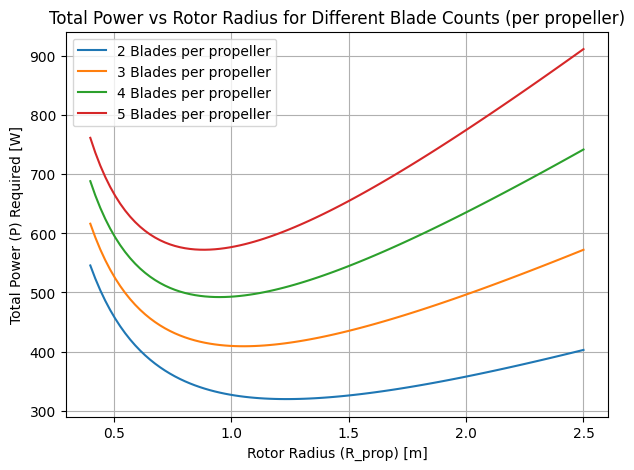

In [35]:
# Data and test values
n_prop = 2 #number of propellers
n_blade_list = [2,3,4,5] #number of blades per propeller

R_prop_guess = 1.5 #m (initial guess for the rotor radius)

compare_blades(n_blade_list, n_prop, R_prop_guess) # Compare different blade counts and plot the results


In [36]:
# Defining a function to find the optimal rotor length

def optimize_rotor_length(n_prop, n_blade, m_total):

    # Defining variable for iteration
    R_prop = symbols('R_prop', positive=True) # rotor radius (m)

    # Thrust calculation with new m_total used in symbolic expression of P
    T = m_total * g_mars # thrust required to hover (N)
    T_rotor = T / n_prop # thrust per rotor (N)

    # Symbolic power expression
    omega = (omega_Ingenuity * R_prop_Ingenuity)/(R_prop)
    P_ideal = (T_rotor**(1.5))/sqrt(2*np.pi*rho_mars*R_prop**2) #W (ideal power required to hover per propeller)
    P_0 = (1/8) * rho_mars * c * n_blade * C_d0 * omega**3 * R_prop**4 #W (power required to hover with losses per propeller)
    P = (gamma * P_ideal + P_0) * n_prop #W (Total power required to hover)

    # Minimize P w.r.t. R_prop
    dP_dR = diff(P, R_prop)
    R_opt = solve(dP_dR, R_prop)
    R_prop_new = R_opt[0]  # Take first valid solution and define as new R_prop

    omega = (omega_Ingenuity * R_prop_Ingenuity)/(R_prop_new)
    P = P.subs(R_prop, R_prop_new).evalf() # Substitute the optimal rotor radius into the power equation

    # New mass calculation based on optimal power
    m_blade = (0.07/4) * n_blade * (R_prop_new/R_prop_Ingenuity) # Weight of blades 
    m_motor = (0.25/2) * ((P/n_prop)/P_motor_Ingenuity) # Weight per motor required per propeller
    m_no_fus = m_constant + m_motor * n_prop + m_blade * n_prop #kg (weight without fuselage)
    m_fus = m_no_fus * (m_fus_Ingenuity / m_no_fus_Ingenuity) #kg (weight of the fuselage)
    m_total_new = m_no_fus + m_fus #kg (total weight of the drone)

    # Flight time in hover
    flight_time = E_battery / P / 60  # converting to minutes

    # Define components based on the final masses
    m_propulsion = m_motor * n_prop  # Propulsion and control motors
    m_rotors = m_blade * n_prop  # Two rotors mass
    m_fuselage = m_fus  # Fuselage

    return {
        'm_total': m_total_new,
        'omega': omega,
        'm_propulsion': m_propulsion,
        'm_rotors': m_rotors,
        'm_fuselage': m_fuselage,
        'R_prop': R_prop_new,
        'P_rotor': P/n_prop,
        'P_total': P,
        'Flight_time': flight_time}  

Iteration 1 :
Total power required to hover:  317.7438 W
Total new mass of the drone:  4.8942 kg

Iteration 2 :
Total power required to hover:  322.1054 W
Total new mass of the drone:  4.9018 kg

Iteration 3 :
Total power required to hover:  322.5544 W
Total new mass of the drone:  4.9026 kg


Optimal rotor radius: 1.2204 m
Total number of blades: 4 blades
Rotation speed: 1376.6402 rpm
Power required per rotor: 158.1537 W
Total power required: 316.3075 W
Total mass of the drone: 4.9225 kg
Flight time in hover: 3.7938 minutes


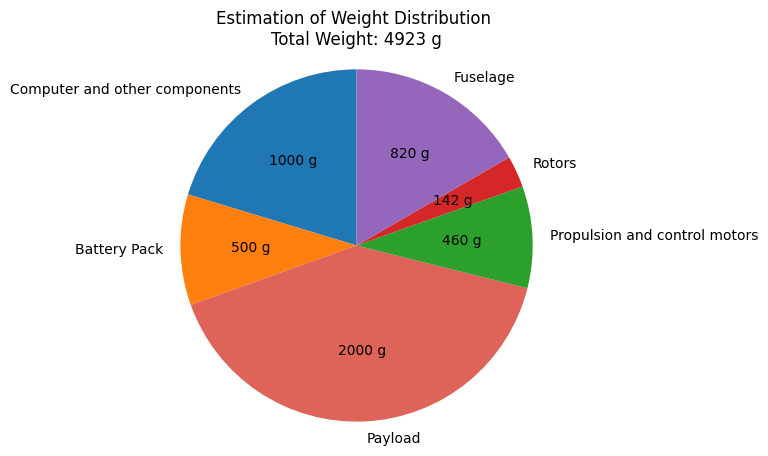

In [37]:
# Final optimal data
n_prop = 2 #number of propellers
n_blade = 2 #number of blades per propeller
N_blade = n_blade * n_prop #number of blades in total
R_prop_guess = 1 #m (initial guess for the rotor radius)

result_duo_mass = Solve_mass(n_prop, n_blade, R_prop_guess) #kg 
m = result_duo_mass['m_total'] #kg (total weight of the drone)

# Call the function to optimize rotor length and equivalent mass
result_duo = optimize_rotor_length(n_prop, n_blade, m)
print()
print('Optimal rotor radius:', round(result_duo['R_prop'].evalf(),4), 'm')
print('Total number of blades:', N_blade, 'blades')
print('Rotation speed:', round(result_duo['omega'] * 60 / (2*pi),4), 'rpm')
print('Power required per rotor:', round(result_duo['P_rotor'].evalf(),4), 'W')
print('Total power required:', round(result_duo['P_total'].evalf(),4), 'W')
print('Total mass of the drone:', round(result_duo['m_total'].evalf(),4), 'kg')
print('Flight time in hover:', round(result_duo['Flight_time'].evalf(),4), 'minutes')


# Data for the pie chart
labels = ['Computer and other components', 'Battery Pack', 'Payload', 'Propulsion and control motors', 'Rotors', 'Fuselage']
sizes = [m_computer, m_battery, payload, result_duo['m_propulsion'], result_duo['m_rotors'], result_duo['m_fuselage']]
sizes_in_grams = [size * 1000 for size in sizes]  # Convert sizes to grams
colors = ['#1f77b4', '#ff7f0e', '#de6459', '#2ca02c', '#d62728', '#9467bd']  # Colors matching the Ingenuity chart
explode = (0, 0, 0, 0, 0, 0)  # No explode effect

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, 
        autopct=lambda p: f'{p * sum(sizes_in_grams) / 100:.0f} g', startangle=90)
plt.title(f"Estimation of Weight Distribution \nTotal Weight: {result_duo['m_total'] * 1000:.0f} g")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Quadcoptor

Iteration 1 :
Total power required to hover:  418.7105 W
Total new mass of the drone:  5.2103 kg

Iteration 2 :
Total power required to hover:  408.7150 W
Total new mass of the drone:  5.1929 kg

Iteration 3 :
Total power required to hover:  407.9651 W
Total new mass of the drone:  5.1916 kg

Iteration 1 :
Total power required to hover:  554.5036 W
Total new mass of the drone:  5.5872 kg

Iteration 2 :
Total power required to hover:  554.8226 W
Total new mass of the drone:  5.5877 kg

Iteration 1 :
Total power required to hover:  690.3749 W
Total new mass of the drone:  5.9641 kg

Iteration 2 :
Total power required to hover:  701.5031 W
Total new mass of the drone:  5.9836 kg

Iteration 3 :
Total power required to hover:  702.3977 W
Total new mass of the drone:  5.9851 kg

Iteration 1 :
Total power required to hover:  826.3235 W
Total new mass of the drone:  6.3413 kg

Iteration 2 :
Total power required to hover:  848.7389 W
Total new mass of the drone:  6.3804 kg

Iteration 3 :
Total 

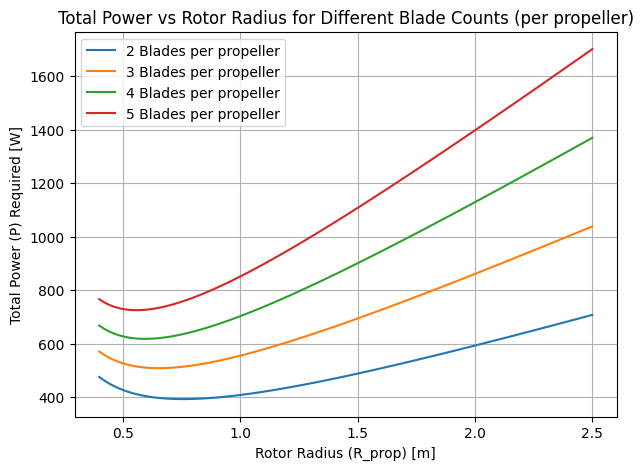

In [38]:
# Data and test values
n_prop = 4 #number of propellers
n_blade_list = [2,3,4,5] #number of blades per propeller

R_prop_guess = 1 #m (initial guess for the rotor radius)

compare_blades(n_blade_list, n_prop, R_prop_guess) # Compare different blade counts and plot the results


Iteration 1 :
Total power required to hover:  418.7105 W
Total new mass of the drone:  5.2103 kg

Iteration 2 :
Total power required to hover:  408.7150 W
Total new mass of the drone:  5.1929 kg

Iteration 3 :
Total power required to hover:  407.9651 W
Total new mass of the drone:  5.1916 kg


Optimal rotor radius: 0.7575 m
Total number of blades: 8 blades
Rotation speed: 2217.8828 rpm
Power required per rotor: 98.1661 W
Total power required: 392.6642 W
Total mass of the drone: 5.0970 kg
Flight time in hover: 3.0560 minutes


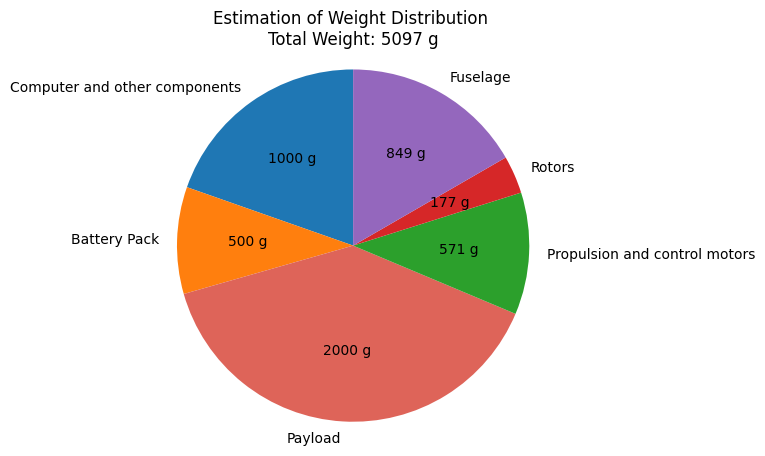

In [39]:
# Final optimal data
n_prop = 4 #number of propellers
n_blade = 2 #number of blades per propeller
N_blade = n_blade * n_prop #number of blades in total
R_prop_guess = 1 #m (initial guess for the rotor radius)

result_duo_mass = Solve_mass(n_prop, n_blade, R_prop_guess) #kg 
m = result_duo_mass['m_total'] #kg (total weight of the drone)

# Call the function to optimize rotor length and equivalent mass
result_duo = optimize_rotor_length(n_prop, n_blade, m)
print()
print('Optimal rotor radius:', round(result_duo['R_prop'].evalf(),4), 'm')
print('Total number of blades:', N_blade, 'blades')
print('Rotation speed:', round(result_duo['omega'] * 60 / (2*pi),4), 'rpm')
print('Power required per rotor:', round(result_duo['P_rotor'].evalf(),4), 'W')
print('Total power required:', round(result_duo['P_total'].evalf(),4), 'W')
print('Total mass of the drone:', round(result_duo['m_total'].evalf(),4), 'kg')
print('Flight time in hover:', round(result_duo['Flight_time'].evalf(),4), 'minutes')

# Data for the pie chart
labels = ['Computer and other components', 'Battery Pack', 'Payload', 'Propulsion and control motors', 'Rotors', 'Fuselage']
sizes = [m_computer, m_battery, payload, result_duo['m_propulsion'], result_duo['m_rotors'], result_duo['m_fuselage']]
sizes_in_grams = [size * 1000 for size in sizes]  # Convert sizes to grams
colors = ['#1f77b4', '#ff7f0e', '#de6459', '#2ca02c', '#d62728', '#9467bd']  # Colors matching the Ingenuity chart
explode = (0, 0, 0, 0, 0, 0)  # No explode effect

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, 
        autopct=lambda p: f'{p * sum(sizes_in_grams) / 100:.0f} g', startangle=90)
plt.title(f"Estimation of Weight Distribution \nTotal Weight: {result_duo['m_total'] * 1000:.0f} g")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


## Task 3

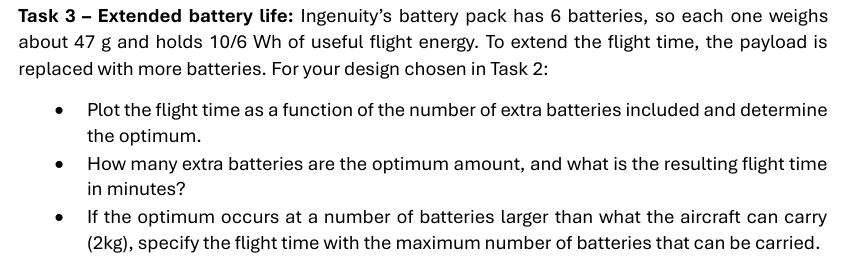


Task 3: Extended Battery Life
{'m_total': 5.09697361664478, 'omega': 73.929427659185*pi, 'm_propulsion': 0.570732878944083, 'm_rotors': 0.176745134926569, 'm_fuselage': 0.849495602774130, 'R_prop': 0.757479149685295, 'P_rotor': 98.1660551783822, 'P_total': 392.664220713529, 'Flight_time': 3.05604620105041}


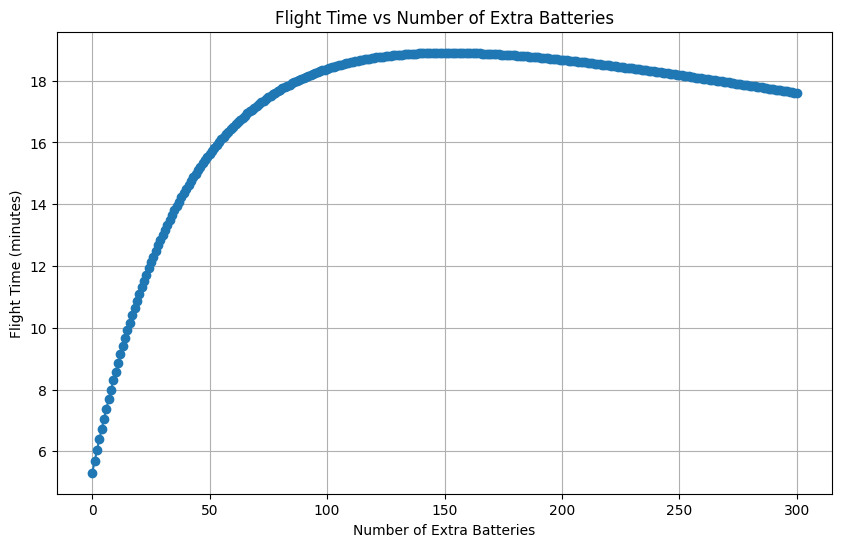

In [45]:
# Task 3: Extended Battery Life
print("\nTask 3: Extended Battery Life")

# Battery specs (Ingenuity)
m_battery_unit = 0.047  # kg (47 g per battery)
E_battery_unit = (10 / 6) * 3600  # J (10/6 Wh per battery)

# Chosen design from Task 2
chosen_design = result_duo  # Chosen design 
print(chosen_design)
n_prop = 2  # Number of propellers

# Function to calculate flight time for a given number of extra batteries
def flight_time_with_extra_batteries(n_extra):
    
    # Mass: "To extend the flight time, the payload is replaced with more batteries"
    m_extra_batteries = n_extra * m_battery_unit  # kg
    m_total_new = chosen_design['m_total'] - payload + m_extra_batteries  # kg
    
    # Thrust calculation with new m_total used in symbolic expression of P
    T = m_total_new * g_mars # thrust required to hover (N)
    T_rotor = T / n_prop # thrust per rotor (N)

    # Symbolic power expression
    omega = (omega_Ingenuity * R_prop_Ingenuity)/(chosen_design['R_prop'])
    P_ideal = (T_rotor**(1.5))/sqrt(2*np.pi*rho_mars*chosen_design['R_prop']**2) #W (ideal power required to hover per propeller)
    P_0 = (1/8) * rho_mars * c * n_blade * C_d0 * omega**3 * chosen_design['R_prop']**4 #W (power required to hover with losses per propeller)
    P = (gamma * P_ideal + P_0) * n_prop #W (Total power required to hover)
    
    # Energy: Original + extra batteries
    E_total = E_battery + n_extra * E_battery_unit  # Js
    flight_time = E_total / P / 60  # minutes
    return flight_time, m_total_new, P


# Calculate flight time for different numbers of extra batteries
n_extra_batteries = np.arange(0, 301)  # Number of extra batteries (0 to 300)
flight_times = []
for n_extra in n_extra_batteries:
    flight_time, m_total_new, P_total_new = flight_time_with_extra_batteries(n_extra)
    flight_times.append(flight_time)

plt.figure(figsize=(10, 6))
plt.plot(n_extra_batteries, flight_times, label='Flight Time', marker='o')
plt.title('Flight Time vs Number of Extra Batteries')
plt.xlabel('Number of Extra Batteries')
plt.ylabel('Flight Time (minutes)')
plt.grid()
plt.show()


In [46]:
# Evaluating number of batteries near visual optimum to determine the best number of batteries
n_extra_batteries = np.arange(140, 160)  # Number of extra batteries (100 to 125)
flight_times = []
for n_extra in n_extra_batteries:
    flight_time, m_total_new, P_total_new = flight_time_with_extra_batteries(n_extra)
    flight_times.append(flight_time)
    print(f"Number of extra batteries: {n_extra}, Flight time: {flight_time:.4f} minutes")


Number of extra batteries: 140, Flight time: 18.8877 minutes
Number of extra batteries: 141, Flight time: 18.8910 minutes
Number of extra batteries: 142, Flight time: 18.8939 minutes
Number of extra batteries: 143, Flight time: 18.8965 minutes
Number of extra batteries: 144, Flight time: 18.8988 minutes
Number of extra batteries: 145, Flight time: 18.9008 minutes
Number of extra batteries: 146, Flight time: 18.9025 minutes
Number of extra batteries: 147, Flight time: 18.9039 minutes
Number of extra batteries: 148, Flight time: 18.9050 minutes
Number of extra batteries: 149, Flight time: 18.9058 minutes
Number of extra batteries: 150, Flight time: 18.9064 minutes
Number of extra batteries: 151, Flight time: 18.9066 minutes
Number of extra batteries: 152, Flight time: 18.9066 minutes
Number of extra batteries: 153, Flight time: 18.9063 minutes
Number of extra batteries: 154, Flight time: 18.9058 minutes
Number of extra batteries: 155, Flight time: 18.9050 minutes
Number of extra batterie

Optimal number of batteries for maximum extra flight time is therefore: 152, resulting in flight time: 18.9012 minutes

In [42]:
# Resulting mass from the batteries
print("\nMass of the batteries:", 152 * m_battery_unit, "kg")



Mass of the batteries: 7.144 kg


This is much larger than the payload. \
As seen on the plot, flight time increases with batteri units, therefore we calculate max batteri units in payload

In [43]:
x = symbols('x', positive=True)  # Number of batteries to replace the payload
eq = Eq(m_battery_unit * x, payload)  # Equation
solve(eq, x)  # Solve for the number of batteries to replace the payload

In [44]:
n_bat = 42  # Number of batteries to replace the payload
full_battery_flight = flight_time_with_extra_batteries(n_bat) # Calculate flight time with the new number of batteries
print(f"Flight time with {n_bat} batteries: {full_battery_flight[0]:.4f} minutes")

Flight time with 42 batteries: 14.7459 minutes
